# __Neural Network__ (Conv2D; fasion_mnist)

Створити `згорткову нейромережу` за допомогою механізмів `Keras`, яка буде класифікувати товари із датасету `fasion_mnist`.

In [176]:
import math
import os
import random
from typing import Optional, Union

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import mish, relu, sigmoid, softmax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import losses
from keras import metrics
from keras import models
from keras import optimizers
from keras.optimizers import Optimizer
from sklearn.model_selection import train_test_split


In [59]:
def set_seed(seed_value: int) -> None:
    """Set a random state for repeatability of results."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    

set_seed(1)

### __`OBTAIN` & `SCRUB`__ + __`EXPLORE`__ (DATASET)

- https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data

In [60]:
(images_train, labels_train), (images_test, labels_test) = fashion_mnist.load_data()
images_train.dtype, images_train[0].shape

(dtype('uint8'), (28, 28))

In [61]:
# hyperparameters+
cfg = {
       #'learning_rate': 0.001,
       # 'training_steps': 3000,
       'batch_size': 64, # для перерахунку ваг не на всій вибірці
       # 'display_step': 100,
       #'n_hidden_1': 256,
       #'n_hidden_2': 64,
       # 'buffer_size': 5000,
       'epochs_limit': 10,
       }

In [62]:
cfg['num_features'] = images_train[0].shape[0] * images_train[0].shape[1]
cfg.get('num_features')

784

In [63]:
images_train, images_test = np.array(images_train, np.float32), np.array(images_test, np.float32)  # .astype('float32')

print(min(images_train.min(), images_test.min()))
maximum = max(images_train.max(), images_test.max()) # np.max([images_train.max(), images_test.max()]) 
maximum

0.0


255.0

In [64]:
# Normalize (min = 0):
images_train, images_test = images_train / maximum, images_test / maximum

In [65]:
images_train.shape, images_test.shape, labels_train.shape, labels_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [66]:
max(labels_train.max(), labels_test.max()), min(labels_train.min(), labels_test.min())

(9, 0)

In [67]:
cfg['num_classes'] = len(set(np.concatenate((labels_train, labels_test), axis=0)))
cfg.get('num_classes')

10

In [68]:
images_valid, images_test, labels_valid, labels_test = train_test_split(
                                                                        images_test, 
                                                                        labels_test, 
                                                                        test_size=0.5,  # 50% for test
                                                                        shuffle=True, 
                                                                        stratify=labels_test
                                                                        )  # (stratify для рівномірного розподілу за значенням y = labels_test)

In [69]:
images_valid.shape, images_test.shape, labels_valid.shape, labels_test.shape

((5000, 28, 28), (5000, 28, 28), (5000,), (5000,))

In [70]:
labels_train = tf.one_hot(labels_train, depth=cfg.get('num_classes')).numpy()
labels_test = tf.one_hot(labels_test, depth=cfg.get('num_classes')).numpy()
labels_valid = tf.one_hot(labels_valid, depth=cfg.get('num_classes')).numpy()
# labels_train = to_categorical(labels_train, num_classes = cfg.get('num_classes'))
# labels_test = to_categorical(labels_test, num_classes = cfg.get('num_classes'))
# labels_valid = to_categorical(labels_valid, num_classes = cfg.get('num_classes'))
labels_train.shape, labels_test.shape, labels_valid.shape  # ((60000, 10), (10000, 10)) to ((60000, 10), (5000, 10), (5000, 10))

((60000, 10), (5000, 10), (5000, 10))

In [71]:
images_train.shape, images_test.shape, images_valid.shape, labels_train.shape, labels_test.shape, labels_valid.shape

((60000, 28, 28),
 (5000, 28, 28),
 (5000, 28, 28),
 (60000, 10),
 (5000, 10),
 (5000, 10))

### __`MODEL`__

- https://keras.io/api/layers/convolution_layers/convolution2d/
- https://keras.io/api/layers/pooling_layers/max_pooling2d/
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten

In [72]:
cfg['kernel_window_size_1'] = 3  # 5, 9, 11
cfg['kernel_window_size_2'] = 3  # 5, 9, 11
cfg['kernel_window_size_3'] = 3  # 5, 9, 11
cfg['filters_1'] = 32  # output_depth
cfg['filters_2'] = 64
cfg['filters_3'] = 64
cfg['filters_4'] = 64
# activation_functions = ['relu' for _ in range(4)] + ['softmax']

In [73]:
model = models.Sequential([
                           layers.Conv2D(
                                         cfg.get('filters_1'), 
                                         (cfg.get('kernel_window_size_1'), cfg.get('kernel_window_size_1')), 
                                         activation='relu', 
                                         input_shape=(images_train.shape[1], images_train.shape[2], 1)  # channels 1 - gray, 3 - RGB
                                         ),  
                           layers.MaxPooling2D((2, 2)),

                           layers.Conv2D(
                                         cfg.get('filters_2'), 
                                         (cfg.get('kernel_window_size_2'), cfg.get('kernel_window_size_2')), 
                                         activation='relu'
                                         ),
                           layers.MaxPooling2D((2, 2)),

                           layers.Conv2D(
                                         cfg.get('filters_3'), 
                                         (cfg.get('kernel_window_size_3'), cfg.get('kernel_window_size_3')), 
                                         activation='relu'
                                         ),

                           layers.Flatten(),
                           layers.Dense(
                                        cfg.get('filters_4'), 
                                        activation='relu'
                                        ),

                           layers.Dense(
                                        cfg.get('num_classes'), 
                                        activation='softmax'
                                        )
                           ])

In [74]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_3 (Flatten)         (None, 576)              

In [75]:
model.compile(
              optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

#### __`Training`__

In [78]:
history = model.fit(
                    images_train, 
                    labels_train,
                    epochs=cfg.get('epochs_limit'),
                    batch_size=cfg.get('batch_size'),
                    validation_data=(images_valid, labels_valid)
                    )

Epoch 1/10
938/938 [==============================] - 10s 10ms/step - loss: 0.5508 - accuracy: 0.7961 - val_loss: 0.4771 - val_accuracy: 0.8260
Epoch 2/10
938/938 [==============================] - 9s 10ms/step - loss: 0.3297 - accuracy: 0.8815 - val_loss: 0.3362 - val_accuracy: 0.8804
Epoch 3/10
938/938 [==============================] - 9s 10ms/step - loss: 0.2804 - accuracy: 0.8978 - val_loss: 0.3195 - val_accuracy: 0.8860
Epoch 4/10
938/938 [==============================] - 9s 10ms/step - loss: 0.2502 - accuracy: 0.9083 - val_loss: 0.2999 - val_accuracy: 0.8884
Epoch 5/10
938/938 [==============================] - 9s 10ms/step - loss: 0.2266 - accuracy: 0.9160 - val_loss: 0.2939 - val_accuracy: 0.9024
Epoch 6/10
938/938 [==============================] - 9s 10ms/step - loss: 0.2090 - accuracy: 0.9236 - val_loss: 0.2879 - val_accuracy: 0.8990
Epoch 7/10
938/938 [==============================] - 9s 10ms/step - loss: 0.1926 - accuracy: 0.9292 - val_loss: 0.2746 - val_accuracy: 0.904

In [80]:
# history = model.fit(images_train, labels_train, epochs=cfg.get('epochs_limit'), batch_size=cfg.get('batch_size'))  # w/o valid data

### __`INTERPRET`__ / __`Error Analysis`__

In [79]:
history.history

{'loss': [0.5507529973983765,
  0.329708993434906,
  0.28040334582328796,
  0.25023576617240906,
  0.22661636769771576,
  0.20899559557437897,
  0.19260458648204803,
  0.17973852157592773,
  0.16533580422401428,
  0.154130756855011],
 'accuracy': [0.7960833311080933,
  0.8815333247184753,
  0.8977833390235901,
  0.9082666635513306,
  0.9160333275794983,
  0.9236000180244446,
  0.9291666746139526,
  0.9343666434288025,
  0.9390666484832764,
  0.942716658115387],
 'val_loss': [0.4770568907260895,
  0.33618971705436707,
  0.3195383846759796,
  0.29991888999938965,
  0.29386284947395325,
  0.28794047236442566,
  0.2745878994464874,
  0.2609300911426544,
  0.29760101437568665,
  0.3447624742984772],
 'val_accuracy': [0.8259999752044678,
  0.8804000020027161,
  0.8859999775886536,
  0.8884000182151794,
  0.902400016784668,
  0.8989999890327454,
  0.9039999842643738,
  0.9093999862670898,
  0.9003999829292297,
  0.8924000263214111]}

In [48]:
# history.history

{'loss': [0.5503414273262024,
  0.34423404932022095,
  0.29211217164993286,
  0.26010194420814514,
  0.2353711873292923,
  0.21603602170944214,
  0.19737708568572998,
  0.1844916045665741,
  0.16968588531017303,
  0.1594318300485611],
 'accuracy': [0.7961500287055969,
  0.8759333491325378,
  0.8929166793823242,
  0.9045166373252869,
  0.9129666686058044,
  0.9210833311080933,
  0.9265000224113464,
  0.9314166903495789,
  0.9378666877746582,
  0.9406333565711975]}

In [52]:
# valid_loss, valid_acc = model.evaluate(images_valid, labels_valid)
# print(valid_acc)
# test_loss, test_acc = model.evaluate(images_test, labels_test)
# print(test_acc)

157/157 [==============================] - 0s 3ms/step - loss: 0.3325 - accuracy: 0.8952
0.8952000141143799
157/157 [==============================] - 0s 3ms/step - loss: 0.3119 - accuracy: 0.8966
0.8966000080108643


In [81]:
def draw_2twin_2d(y00: np.array, y01: np.array, y10: np.array, y11: np.array, suptitle: str) -> None:
    x = range(1, len(y00) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))

    axs[0].plot(x, y00, 'bo', label='Training loss')
    axs[0].plot(x, y01, 'g', label='Validation loss')
    axs[0].title.set_text('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(x, y10, 'bo', label='Training acc')
    axs[1].plot(x, y11, 'g', label='Validation acc')
    axs[1].title.set_text('Training and validation acc')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Acc')
    axs[1].legend()
    axs[1].grid()
    
    fig.suptitle(suptitle)
    # plt.legend()
    # plt.grid()
    axs[1].grid()
    plt.show()

In [82]:
history_dict

{'loss': [0.5503414273262024,
  0.34423404932022095,
  0.29211217164993286,
  0.26010194420814514,
  0.2353711873292923,
  0.21603602170944214,
  0.19737708568572998,
  0.1844916045665741,
  0.16968588531017303,
  0.1594318300485611],
 'accuracy': [0.7961500287055969,
  0.8759333491325378,
  0.8929166793823242,
  0.9045166373252869,
  0.9129666686058044,
  0.9210833311080933,
  0.9265000224113464,
  0.9314166903495789,
  0.9378666877746582,
  0.9406333565711975]}

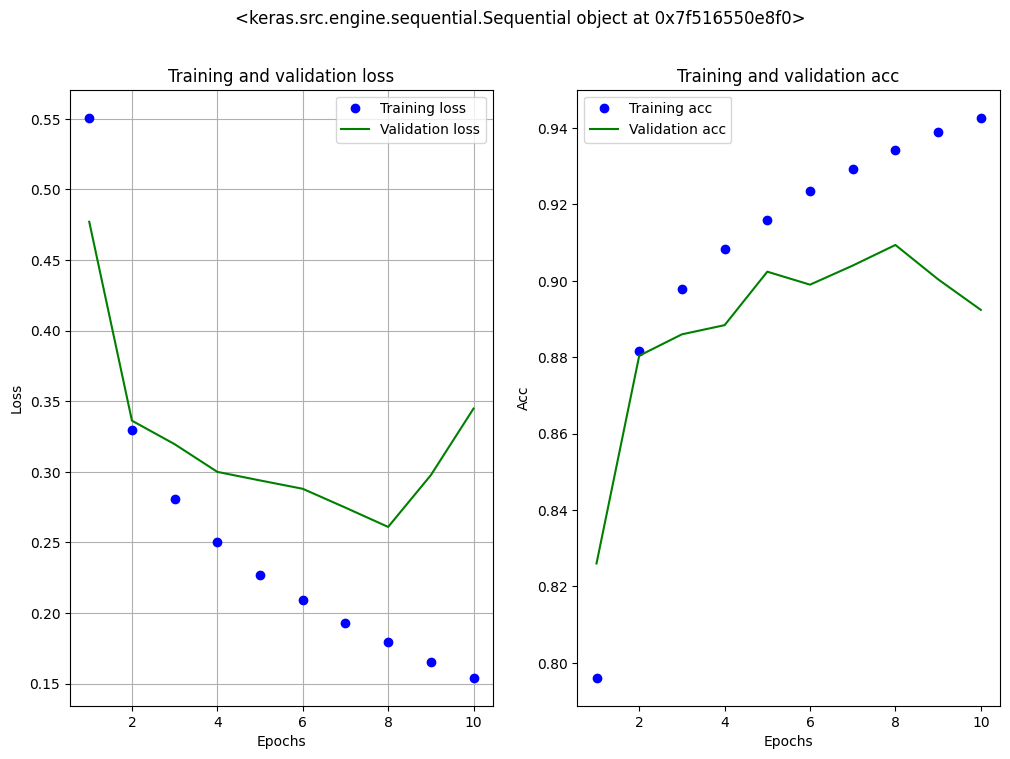

In [83]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']   

draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=model)

# .......................

- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer
- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/legacy/RMSprop

In [193]:
class ModelConv2D:
    def __init__(self, input_shape: tuple, filters: list, kernel_window_sizes: list, activations: list) -> None:
        self.model = models.Sequential(
                                       [
                                        layers.Conv2D(
                                                      filters[0], 
                                                      (kernel_window_sizes[0], kernel_window_sizes[0]), 
                                                      activation=activations[0], 
                                                      input_shape=input_shape
                                                      ),  
                                        layers.MaxPooling2D((2, 2)),

                                        layers.Conv2D(
                                                      filters[1], 
                                                      (kernel_window_sizes[1], kernel_window_sizes[1]), 
                                                      activation=activations[1]
                                                      ),
                                        layers.MaxPooling2D((2, 2)),

                                        layers.Conv2D(
                                                      filters[2], 
                                                      (kernel_window_sizes[2], kernel_window_sizes[2]), 
                                                      activation=activations[2]
                                                      ),

                                        layers.Flatten(),
                                        layers.Dense(
                                                     filters[3], 
                                                     activation=activations[3]
                                                     ),

                                        layers.Dense(
                                                     filters[4], 
                                                     activation=activations[4]
                                                     )
                                        ])
        self.model.__name__ = 'newone'
        
    def compile(self, opt: Union[str, Optimizer], loss: Union[str, losses.CategoricalCrossentropy()], metrics: list) -> None:
        self.model.compile(
                           optimizer=opt,
                           loss=loss,
                           metrics=metrics
                           )

    def summary(self) -> None:
        self.model.summary()
    

In [194]:
model = ModelConv2D(
                    input_shape=(images_train.shape[1], images_train.shape[2], 1),   # channels 1 - gray, 3 - RGB
                    filters=[cfg.get('filters_1'), cfg.get('filters_2'), cfg.get('filters_3'), cfg.get('filters_4'), cfg.get('num_classes')],
                    kernel_window_sizes=[cfg.get('kernel_window_size_1'), cfg.get('kernel_window_size_2'), cfg.get('kernel_window_size_3')],
                    activations=['relu', 'relu', 'relu', 'relu', 'softmax'],
                    )
# model.compile(opt='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# optimizers.legacy.SGD, optimizers.legacy.RMSprop, optimizers.legacy.Adam   # metrics.BinaryAccuracy()  CategoricalAccuracy()
model.compile(opt=optimizers.legacy.RMSprop(learning_rate=0.001), loss=losses.CategoricalCrossentropy(), metrics=metrics.CategoricalAccuracy())

In [195]:
type(model), type(model.model)

(__main__.ModelConv2D, keras.src.engine.sequential.Sequential)

In [196]:
model.model.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_177 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_118 (MaxPool  (None, 13, 13, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_178 (Conv2D)         (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_119 (MaxPool  (None, 5, 5, 64)          0         
 ing2D)                                                          
                                                                 
 conv2d_179 (Conv2D)         (None, 3, 3, 64)          36928     
                                                                 
 flatten_59 (Flatten)        (None, 576)             

In [197]:
model.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_177 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_118 (MaxPool  (None, 13, 13, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_178 (Conv2D)         (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_119 (MaxPool  (None, 5, 5, 64)          0         
 ing2D)                                                          
                                                                 
 conv2d_179 (Conv2D)         (None, 3, 3, 64)          36928     
                                                                 
 flatten_59 (Flatten)        (None, 576)             

In [198]:
class TrainerModelConv2D:
    def __init__(self, model: ModelConv2D) -> None:
        self.model = model.model

    def train(self, x: np.ndarray, y: np.ndarray, epochs: int, batch_size: int, validation_data: Optional[tuple]=None) -> None:
        self.history = self.model.fit(
                                      x=x, 
                                      y=y,
                                      epochs=epochs,
                                      batch_size=batch_size,
                                      validation_data=validation_data
                                      )
        
    def draw_results(self, caption: str) -> None:  # ! categorical_accuracy or accuracy ? exclude function
        history_dict = self.history.history

        loss_values = history_dict['loss']
        val_loss_values = history_dict['val_loss']
        acc_values = history_dict['categorical_accuracy']
        val_acc_values = history_dict['val_categorical_accuracy']   

        draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=caption)

    def trained_model(self) -> models.Sequential():
        return self.model

Epoch 1/8
938/938 [==============================] - 9s 10ms/step - loss: 0.1660 - categorical_accuracy: 0.9384 - val_loss: 0.3339 - val_categorical_accuracy: 0.8980
Epoch 2/8
938/938 [==============================] - 9s 10ms/step - loss: 0.1532 - categorical_accuracy: 0.9433 - val_loss: 0.2964 - val_categorical_accuracy: 0.9090
Epoch 3/8
938/938 [==============================] - 9s 10ms/step - loss: 0.1430 - categorical_accuracy: 0.9464 - val_loss: 0.2912 - val_categorical_accuracy: 0.9000
Epoch 4/8
938/938 [==============================] - 9s 10ms/step - loss: 0.1322 - categorical_accuracy: 0.9511 - val_loss: 0.2840 - val_categorical_accuracy: 0.9016
Epoch 5/8
938/938 [==============================] - 9s 10ms/step - loss: 0.1240 - categorical_accuracy: 0.9541 - val_loss: 0.3318 - val_categorical_accuracy: 0.9090
Epoch 6/8
938/938 [==============================] - 9s 10ms/step - loss: 0.1150 - categorical_accuracy: 0.9574 - val_loss: 0.3658 - val_categorical_accuracy: 0.9104
Epoc

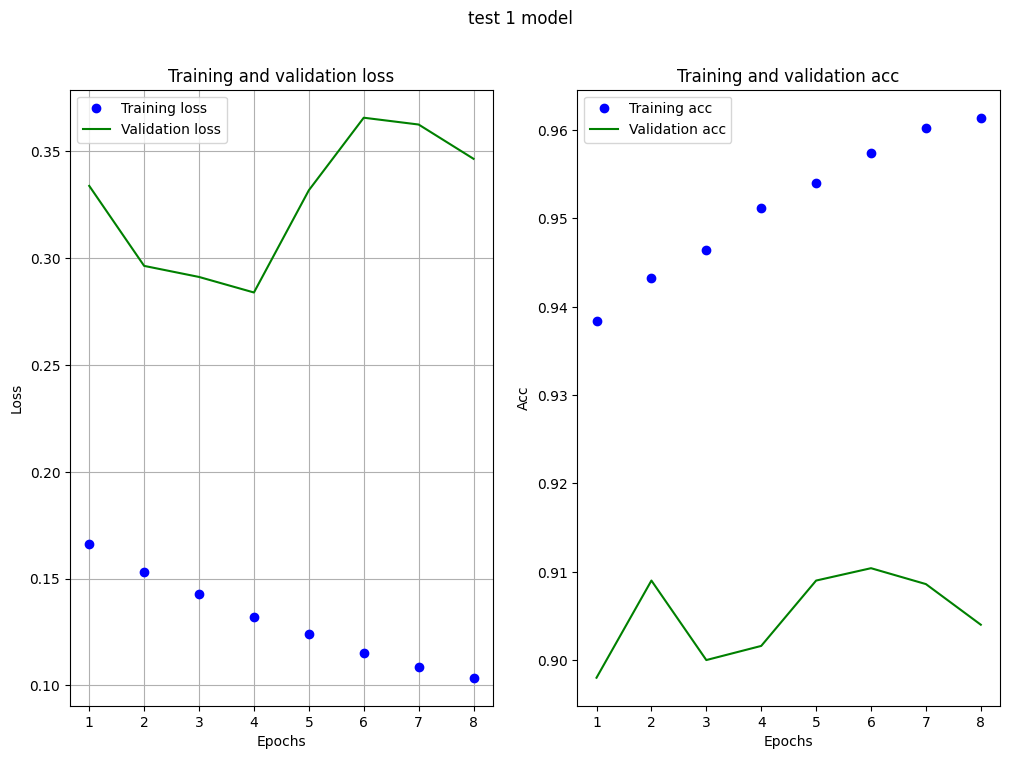

In [200]:
train_1 = TrainerModelConv2D(model)
train_1.train(x=images_train, y=labels_train, epochs=8, batch_size=cfg.get('batch_size'), validation_data=(images_valid, labels_valid))
train_1.draw_results('test 1 model')

In [201]:
train_1.trained_model().summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_177 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_118 (MaxPool  (None, 13, 13, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_178 (Conv2D)         (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_119 (MaxPool  (None, 5, 5, 64)          0         
 ing2D)                                                          
                                                                 
 conv2d_179 (Conv2D)         (None, 3, 3, 64)          36928     
                                                                 
 flatten_59 (Flatten)        (None, 576)             

In [202]:
test_loss, test_acc = train_1.trained_model().evaluate(images_test, labels_test)
print(round(test_acc, 4))

157/157 [==============================] - 0s 3ms/step - loss: 0.3445 - categorical_accuracy: 0.9070
0.907


### model set

In [206]:
my_models = {}
for bs in [64, 256, 512]:
    for opt in [optimizers.legacy.SGD, optimizers.legacy.RMSprop, optimizers.legacy.Adam]:
        for lr in [10**el for el in range(-3, -1)]:
            model = ModelConv2D(
                                input_shape=(images_train.shape[1], images_train.shape[2], 1),   # channels 1 - gray, 3 - RGB
                                filters=[cfg.get('filters_1'), cfg.get('filters_2'), cfg.get('filters_3'), cfg.get('filters_4'), cfg.get('num_classes')],
                                kernel_window_sizes=[cfg.get('kernel_window_size_1'), cfg.get('kernel_window_size_2'), cfg.get('kernel_window_size_3')],
                                activations=['relu', 'relu', 'relu', 'relu', 'softmax'],
                                )
            # model.compile(opt='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
            # optimizers.legacy.SGD, optimizers.legacy.RMSprop, optimizers.legacy.Adam   # metrics.BinaryAccuracy()  CategoricalAccuracy()
            model.compile(opt=opt(learning_rate=lr), loss=losses.CategoricalCrossentropy(), metrics=metrics.CategoricalAccuracy())
            my_models[f'{model.model.name}-{opt()._name}-lr{lr}-bs{bs}'] = model


len(my_models)

18

In [207]:
my_models

{'sequential_89-SGD-lr0.001-bs64': <__main__.ModelConv2D at 0x7f514b181fc0>,
 'sequential_90-SGD-lr0.01-bs64': <__main__.ModelConv2D at 0x7f514b1cfb80>,
 'sequential_91-RMSprop-lr0.001-bs64': <__main__.ModelConv2D at 0x7f514aff3400>,
 'sequential_92-RMSprop-lr0.01-bs64': <__main__.ModelConv2D at 0x7f514affd720>,
 'sequential_93-Adam-lr0.001-bs64': <__main__.ModelConv2D at 0x7f514b00ace0>,
 'sequential_94-Adam-lr0.01-bs64': <__main__.ModelConv2D at 0x7f514b031990>,
 'sequential_95-SGD-lr0.001-bs256': <__main__.ModelConv2D at 0x7f514afff670>,
 'sequential_96-SGD-lr0.01-bs256': <__main__.ModelConv2D at 0x7f514b060e20>,
 'sequential_97-RMSprop-lr0.001-bs256': <__main__.ModelConv2D at 0x7f514b081630>,
 'sequential_98-RMSprop-lr0.01-bs256': <__main__.ModelConv2D at 0x7f514b0b66b0>,
 'sequential_99-Adam-lr0.001-bs256': <__main__.ModelConv2D at 0x7f514eff50f0>,
 'sequential_100-Adam-lr0.01-bs256': <__main__.ModelConv2D at 0x7f514b1ccfa0>,
 'sequential_101-SGD-lr0.001-bs512': <__main__.ModelCon

### Training mosel set

Epoch 1/10
938/938 [==============================] - 9s 10ms/step - loss: 2.2636 - categorical_accuracy: 0.1632 - val_loss: 2.2251 - val_categorical_accuracy: 0.2394
Epoch 2/10
938/938 [==============================] - 9s 9ms/step - loss: 2.1379 - categorical_accuracy: 0.2531 - val_loss: 1.9958 - val_categorical_accuracy: 0.2976
Epoch 3/10
938/938 [==============================] - 9s 9ms/step - loss: 1.6918 - categorical_accuracy: 0.3882 - val_loss: 1.3489 - val_categorical_accuracy: 0.5162
Epoch 4/10
938/938 [==============================] - 9s 9ms/step - loss: 1.1161 - categorical_accuracy: 0.6101 - val_loss: 0.9758 - val_categorical_accuracy: 0.6602
Epoch 5/10
938/938 [==============================] - 9s 9ms/step - loss: 0.9121 - categorical_accuracy: 0.6688 - val_loss: 0.8785 - val_categorical_accuracy: 0.6772
Epoch 6/10
938/938 [==============================] - 9s 9ms/step - loss: 0.8491 - categorical_accuracy: 0.6874 - val_loss: 0.9031 - val_categorical_accuracy: 0.6648
Epo

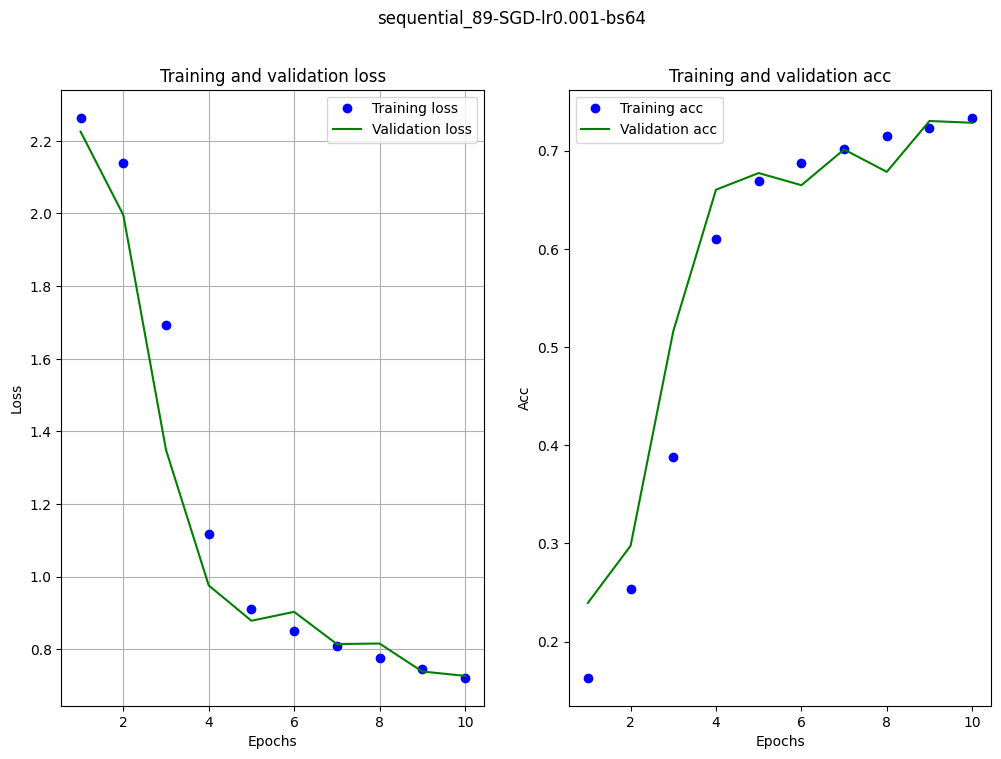

Epoch 1/10
938/938 [==============================] - 9s 9ms/step - loss: 1.1070 - categorical_accuracy: 0.6038 - val_loss: 0.8025 - val_categorical_accuracy: 0.7026
Epoch 2/10
938/938 [==============================] - 9s 9ms/step - loss: 0.6558 - categorical_accuracy: 0.7516 - val_loss: 0.6315 - val_categorical_accuracy: 0.7686
Epoch 3/10
938/938 [==============================] - 9s 9ms/step - loss: 0.5753 - categorical_accuracy: 0.7836 - val_loss: 0.5951 - val_categorical_accuracy: 0.7740
Epoch 4/10
938/938 [==============================] - 9s 9ms/step - loss: 0.5298 - categorical_accuracy: 0.8016 - val_loss: 0.5473 - val_categorical_accuracy: 0.7946
Epoch 5/10
938/938 [==============================] - 9s 9ms/step - loss: 0.4939 - categorical_accuracy: 0.8177 - val_loss: 0.5077 - val_categorical_accuracy: 0.8160
Epoch 6/10
938/938 [==============================] - 9s 9ms/step - loss: 0.4663 - categorical_accuracy: 0.8296 - val_loss: 0.4891 - val_categorical_accuracy: 0.8174
Epoc

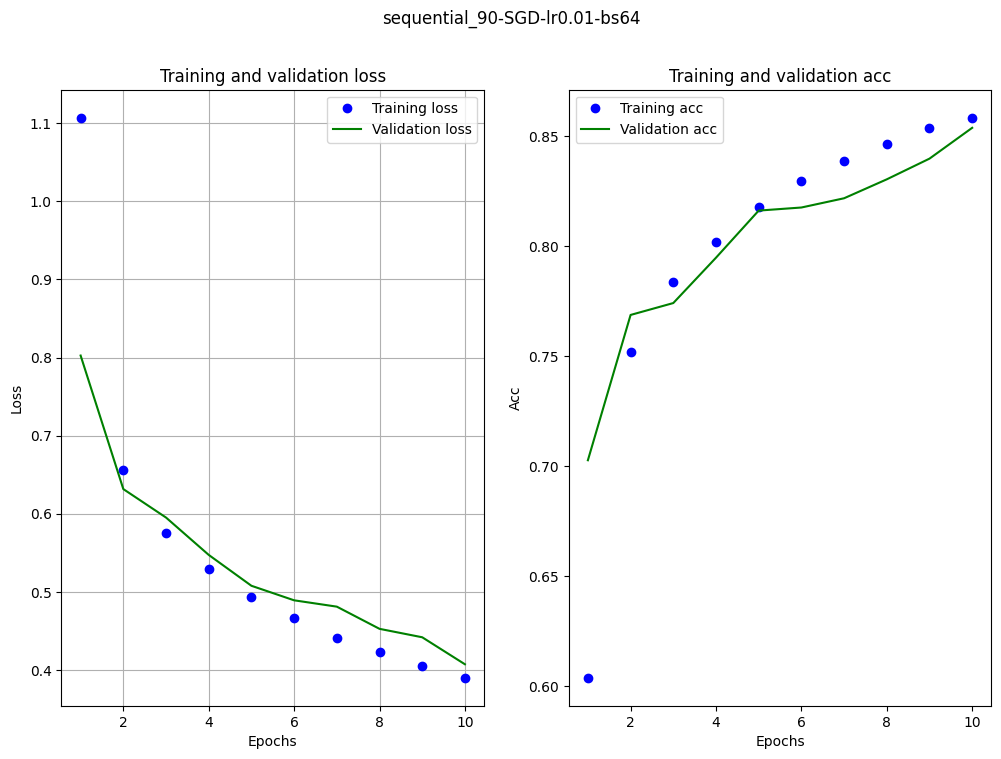

Epoch 1/10
938/938 [==============================] - 10s 10ms/step - loss: 0.5365 - categorical_accuracy: 0.7993 - val_loss: 0.4833 - val_categorical_accuracy: 0.8254
Epoch 2/10
938/938 [==============================] - 9s 9ms/step - loss: 0.3264 - categorical_accuracy: 0.8809 - val_loss: 0.3540 - val_categorical_accuracy: 0.8744
Epoch 3/10
938/938 [==============================] - 9s 9ms/step - loss: 0.2778 - categorical_accuracy: 0.8990 - val_loss: 0.3321 - val_categorical_accuracy: 0.8804
Epoch 4/10
938/938 [==============================] - 9s 9ms/step - loss: 0.2452 - categorical_accuracy: 0.9099 - val_loss: 0.2933 - val_categorical_accuracy: 0.8954
Epoch 5/10
938/938 [==============================] - 9s 9ms/step - loss: 0.2211 - categorical_accuracy: 0.9182 - val_loss: 0.2829 - val_categorical_accuracy: 0.9032
Epoch 6/10
938/938 [==============================] - 9s 9ms/step - loss: 0.2022 - categorical_accuracy: 0.9258 - val_loss: 0.2809 - val_categorical_accuracy: 0.9034
Ep

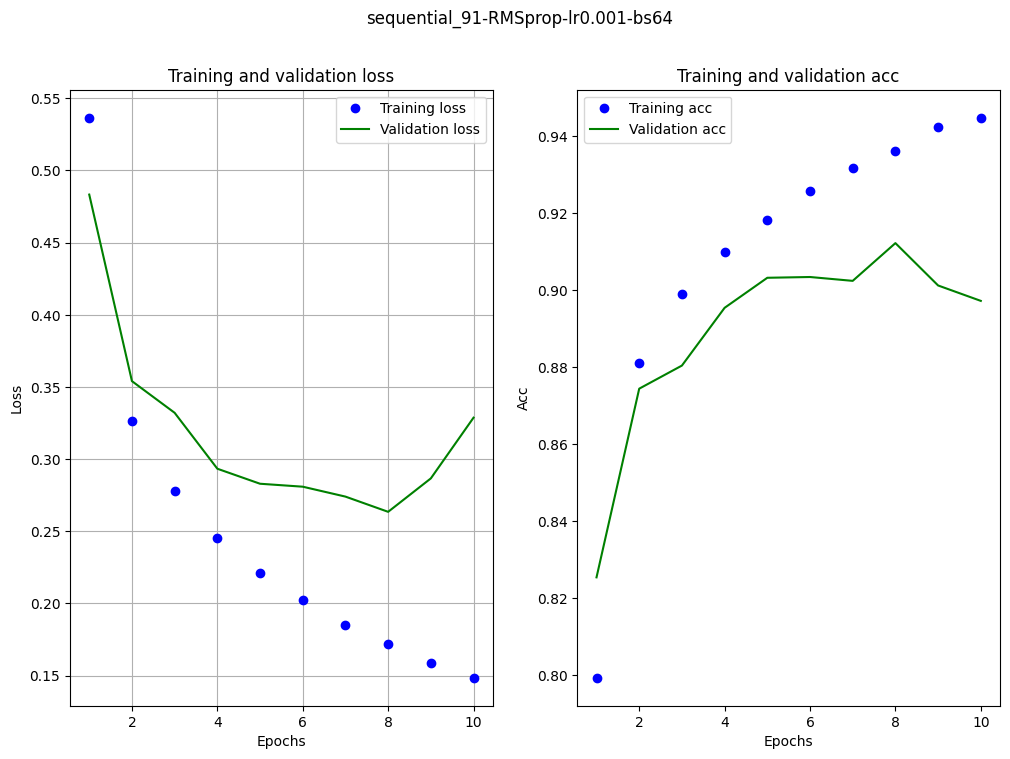

Epoch 1/10
938/938 [==============================] - 9s 10ms/step - loss: 0.5758 - categorical_accuracy: 0.7919 - val_loss: 0.4629 - val_categorical_accuracy: 0.8408
Epoch 2/10
938/938 [==============================] - 9s 10ms/step - loss: 0.4088 - categorical_accuracy: 0.8554 - val_loss: 0.5275 - val_categorical_accuracy: 0.8314
Epoch 3/10
938/938 [==============================] - 9s 9ms/step - loss: 0.4141 - categorical_accuracy: 0.8563 - val_loss: 0.5425 - val_categorical_accuracy: 0.8118
Epoch 4/10
938/938 [==============================] - 9s 9ms/step - loss: 0.4186 - categorical_accuracy: 0.8516 - val_loss: 0.5214 - val_categorical_accuracy: 0.8264
Epoch 5/10
938/938 [==============================] - 9s 9ms/step - loss: 0.4331 - categorical_accuracy: 0.8499 - val_loss: 0.4594 - val_categorical_accuracy: 0.8332
Epoch 6/10
938/938 [==============================] - 9s 9ms/step - loss: 0.4485 - categorical_accuracy: 0.8461 - val_loss: 0.5733 - val_categorical_accuracy: 0.8232
Ep

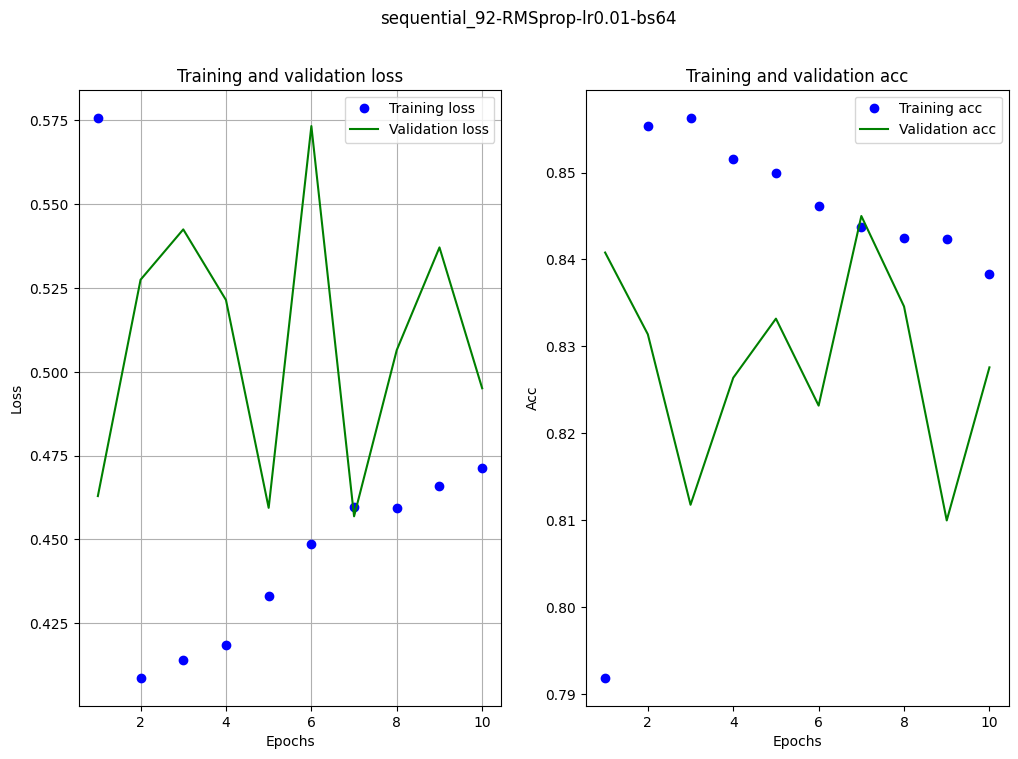

Epoch 1/10
938/938 [==============================] - 9s 10ms/step - loss: 0.5339 - categorical_accuracy: 0.8042 - val_loss: 0.4117 - val_categorical_accuracy: 0.8510
Epoch 2/10
938/938 [==============================] - 9s 10ms/step - loss: 0.3368 - categorical_accuracy: 0.8794 - val_loss: 0.3477 - val_categorical_accuracy: 0.8742
Epoch 3/10
938/938 [==============================] - 9s 10ms/step - loss: 0.2913 - categorical_accuracy: 0.8941 - val_loss: 0.3215 - val_categorical_accuracy: 0.8776
Epoch 4/10
938/938 [==============================] - 9s 10ms/step - loss: 0.2636 - categorical_accuracy: 0.9041 - val_loss: 0.2897 - val_categorical_accuracy: 0.8980
Epoch 5/10
938/938 [==============================] - 9s 10ms/step - loss: 0.2383 - categorical_accuracy: 0.9119 - val_loss: 0.2888 - val_categorical_accuracy: 0.8976
Epoch 6/10
938/938 [==============================] - 9s 9ms/step - loss: 0.2201 - categorical_accuracy: 0.9188 - val_loss: 0.2575 - val_categorical_accuracy: 0.9076

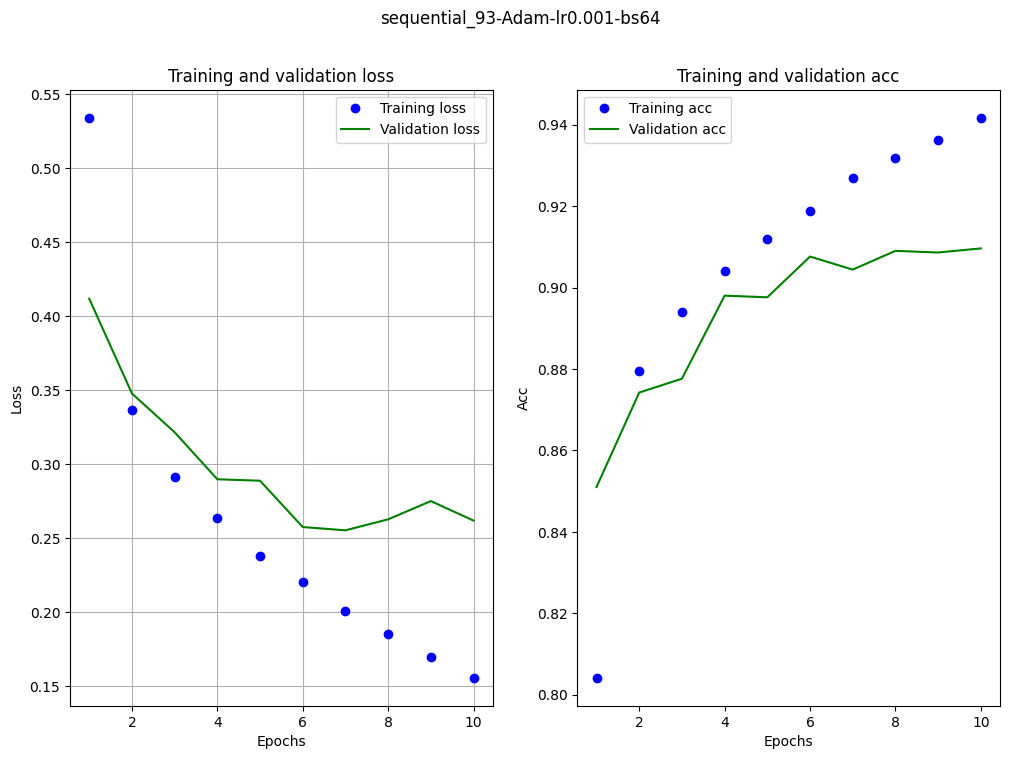

Epoch 1/10
938/938 [==============================] - 9s 10ms/step - loss: 0.5599 - categorical_accuracy: 0.7904 - val_loss: 0.4377 - val_categorical_accuracy: 0.8424
Epoch 2/10
938/938 [==============================] - 9s 10ms/step - loss: 0.3947 - categorical_accuracy: 0.8553 - val_loss: 0.4000 - val_categorical_accuracy: 0.8504
Epoch 3/10
938/938 [==============================] - 9s 10ms/step - loss: 0.3610 - categorical_accuracy: 0.8661 - val_loss: 0.3909 - val_categorical_accuracy: 0.8538
Epoch 4/10
938/938 [==============================] - 9s 9ms/step - loss: 0.3528 - categorical_accuracy: 0.8696 - val_loss: 0.3894 - val_categorical_accuracy: 0.8590
Epoch 5/10
938/938 [==============================] - 9s 9ms/step - loss: 0.3478 - categorical_accuracy: 0.8701 - val_loss: 0.3922 - val_categorical_accuracy: 0.8596
Epoch 6/10
938/938 [==============================] - 9s 10ms/step - loss: 0.3441 - categorical_accuracy: 0.8726 - val_loss: 0.3619 - val_categorical_accuracy: 0.8636


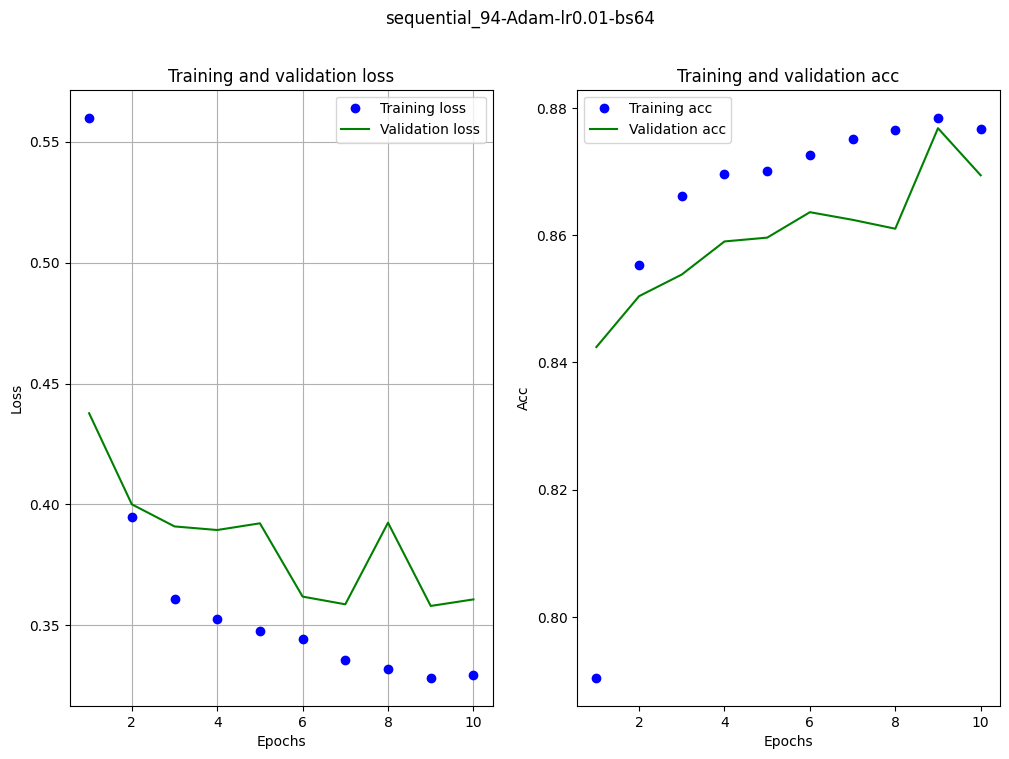

Epoch 1/10
235/235 [==============================] - 8s 31ms/step - loss: 2.2892 - categorical_accuracy: 0.1010 - val_loss: 2.2776 - val_categorical_accuracy: 0.1050
Epoch 2/10
235/235 [==============================] - 7s 31ms/step - loss: 2.2669 - categorical_accuracy: 0.1080 - val_loss: 2.2570 - val_categorical_accuracy: 0.1142
Epoch 3/10
235/235 [==============================] - 7s 31ms/step - loss: 2.2459 - categorical_accuracy: 0.1194 - val_loss: 2.2347 - val_categorical_accuracy: 0.1282
Epoch 4/10
235/235 [==============================] - 7s 31ms/step - loss: 2.2202 - categorical_accuracy: 0.1459 - val_loss: 2.2053 - val_categorical_accuracy: 0.1784
Epoch 5/10
235/235 [==============================] - 7s 31ms/step - loss: 2.1850 - categorical_accuracy: 0.2104 - val_loss: 2.1637 - val_categorical_accuracy: 0.2442
Epoch 6/10
235/235 [==============================] - 7s 31ms/step - loss: 2.1339 - categorical_accuracy: 0.2674 - val_loss: 2.1019 - val_categorical_accuracy: 0.292

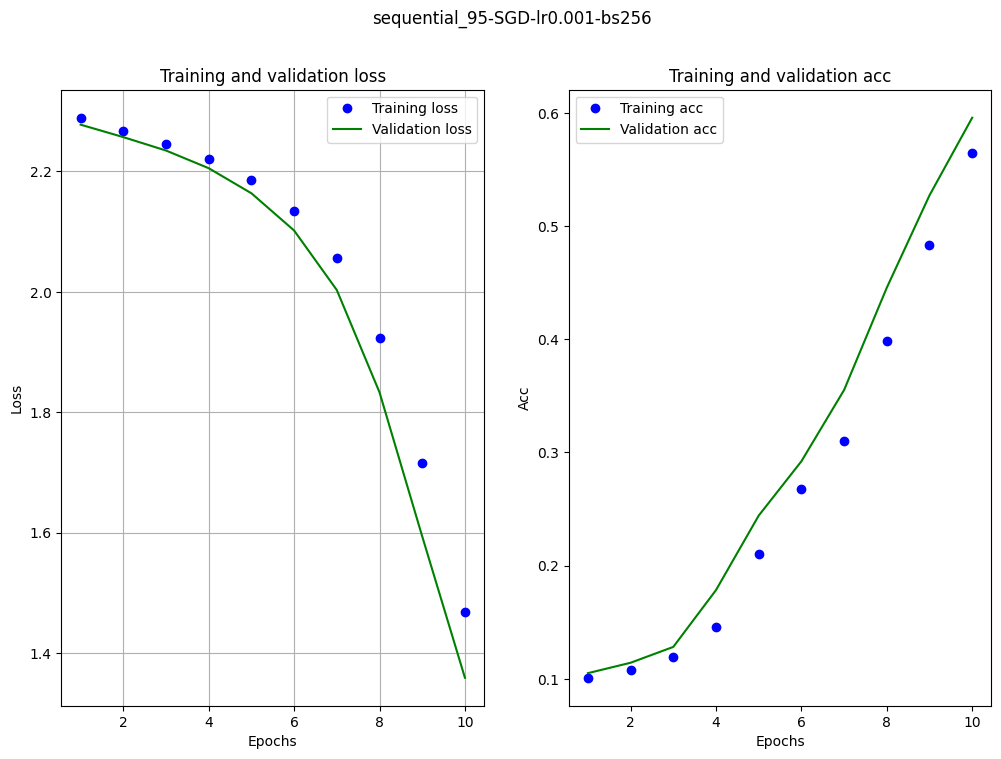

Epoch 1/10
235/235 [==============================] - 8s 32ms/step - loss: 2.0388 - categorical_accuracy: 0.3645 - val_loss: 1.3485 - val_categorical_accuracy: 0.4590
Epoch 2/10
235/235 [==============================] - 7s 31ms/step - loss: 1.0555 - categorical_accuracy: 0.6026 - val_loss: 0.9517 - val_categorical_accuracy: 0.6294
Epoch 3/10
235/235 [==============================] - 7s 31ms/step - loss: 0.8530 - categorical_accuracy: 0.6816 - val_loss: 1.0128 - val_categorical_accuracy: 0.6388
Epoch 4/10
235/235 [==============================] - 7s 31ms/step - loss: 0.7582 - categorical_accuracy: 0.7168 - val_loss: 0.7567 - val_categorical_accuracy: 0.7312
Epoch 5/10
235/235 [==============================] - 7s 31ms/step - loss: 0.7019 - categorical_accuracy: 0.7383 - val_loss: 0.6815 - val_categorical_accuracy: 0.7516
Epoch 6/10
235/235 [==============================] - 7s 31ms/step - loss: 0.6604 - categorical_accuracy: 0.7546 - val_loss: 0.7406 - val_categorical_accuracy: 0.722

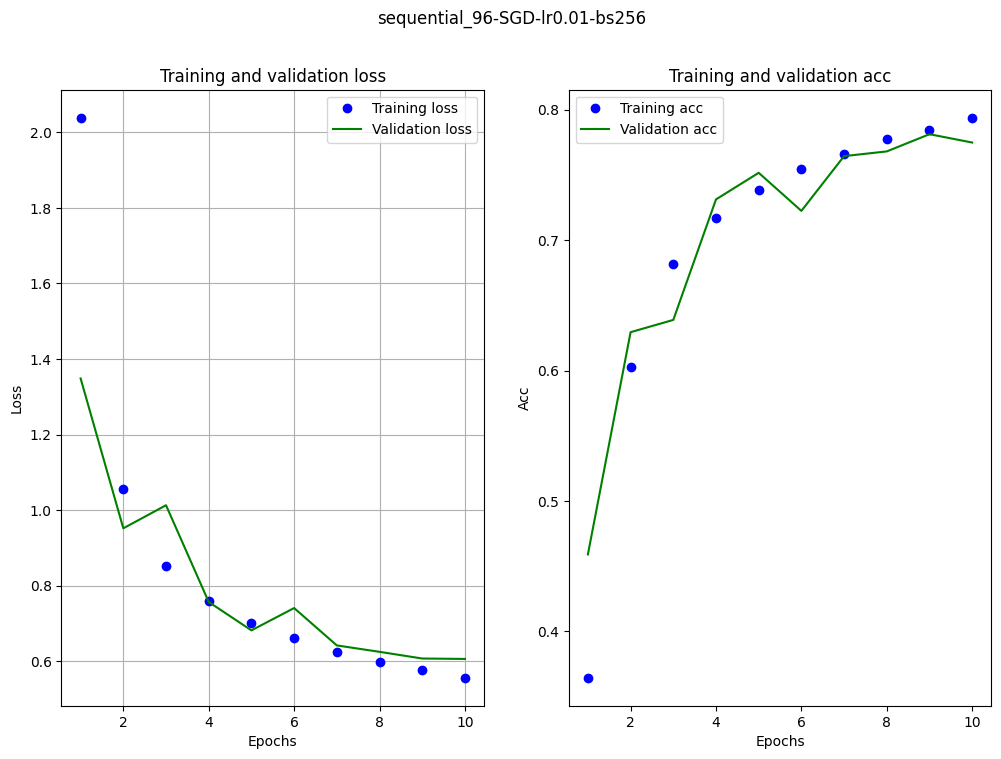

Epoch 1/10
235/235 [==============================] - 8s 31ms/step - loss: 0.7689 - categorical_accuracy: 0.7154 - val_loss: 0.5211 - val_categorical_accuracy: 0.8064
Epoch 2/10
235/235 [==============================] - 7s 31ms/step - loss: 0.4373 - categorical_accuracy: 0.8407 - val_loss: 0.4161 - val_categorical_accuracy: 0.8450
Epoch 3/10
235/235 [==============================] - 7s 31ms/step - loss: 0.3644 - categorical_accuracy: 0.8670 - val_loss: 0.4474 - val_categorical_accuracy: 0.8248
Epoch 4/10
235/235 [==============================] - 7s 31ms/step - loss: 0.3224 - categorical_accuracy: 0.8816 - val_loss: 0.3628 - val_categorical_accuracy: 0.8686
Epoch 5/10
235/235 [==============================] - 7s 31ms/step - loss: 0.2934 - categorical_accuracy: 0.8918 - val_loss: 0.3354 - val_categorical_accuracy: 0.8766
Epoch 6/10
235/235 [==============================] - 7s 31ms/step - loss: 0.2700 - categorical_accuracy: 0.9012 - val_loss: 0.3282 - val_categorical_accuracy: 0.880

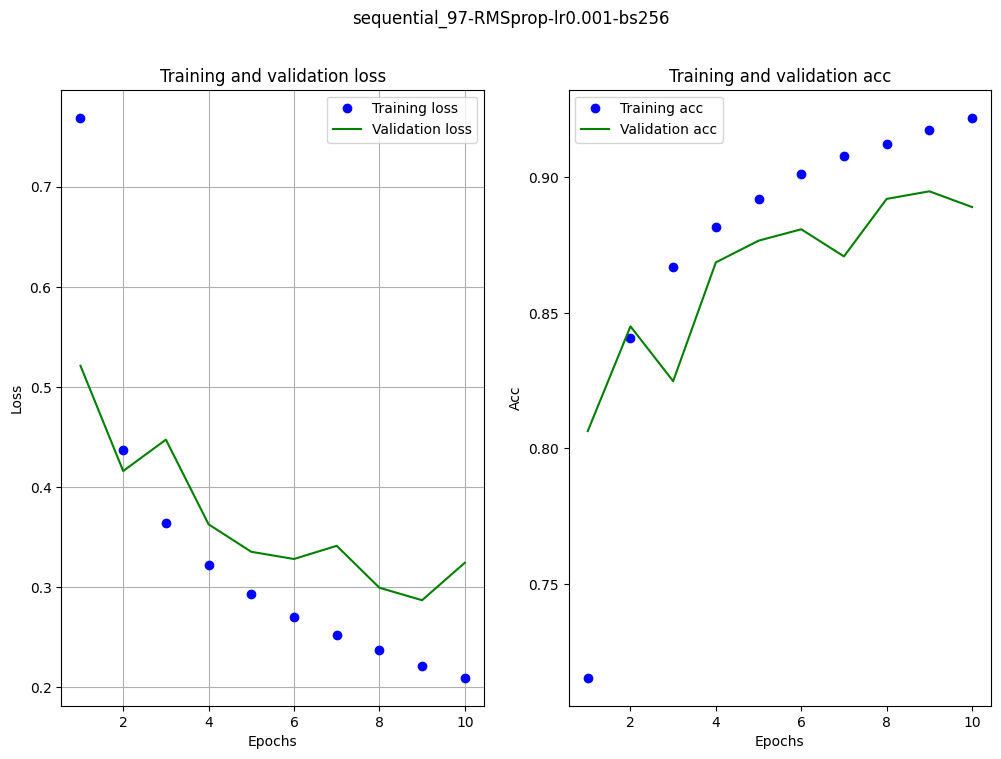

Epoch 1/10
235/235 [==============================] - 8s 31ms/step - loss: 0.8409 - categorical_accuracy: 0.7241 - val_loss: 0.6013 - val_categorical_accuracy: 0.8028
Epoch 2/10
235/235 [==============================] - 7s 31ms/step - loss: 0.3863 - categorical_accuracy: 0.8554 - val_loss: 0.3671 - val_categorical_accuracy: 0.8710
Epoch 3/10
235/235 [==============================] - 7s 31ms/step - loss: 0.3375 - categorical_accuracy: 0.8752 - val_loss: 0.4578 - val_categorical_accuracy: 0.8328
Epoch 4/10
235/235 [==============================] - 7s 31ms/step - loss: 0.3139 - categorical_accuracy: 0.8830 - val_loss: 0.4789 - val_categorical_accuracy: 0.8364
Epoch 5/10
235/235 [==============================] - 7s 31ms/step - loss: 0.2954 - categorical_accuracy: 0.8906 - val_loss: 0.3694 - val_categorical_accuracy: 0.8636
Epoch 6/10
235/235 [==============================] - 7s 31ms/step - loss: 0.2830 - categorical_accuracy: 0.8959 - val_loss: 0.3817 - val_categorical_accuracy: 0.873

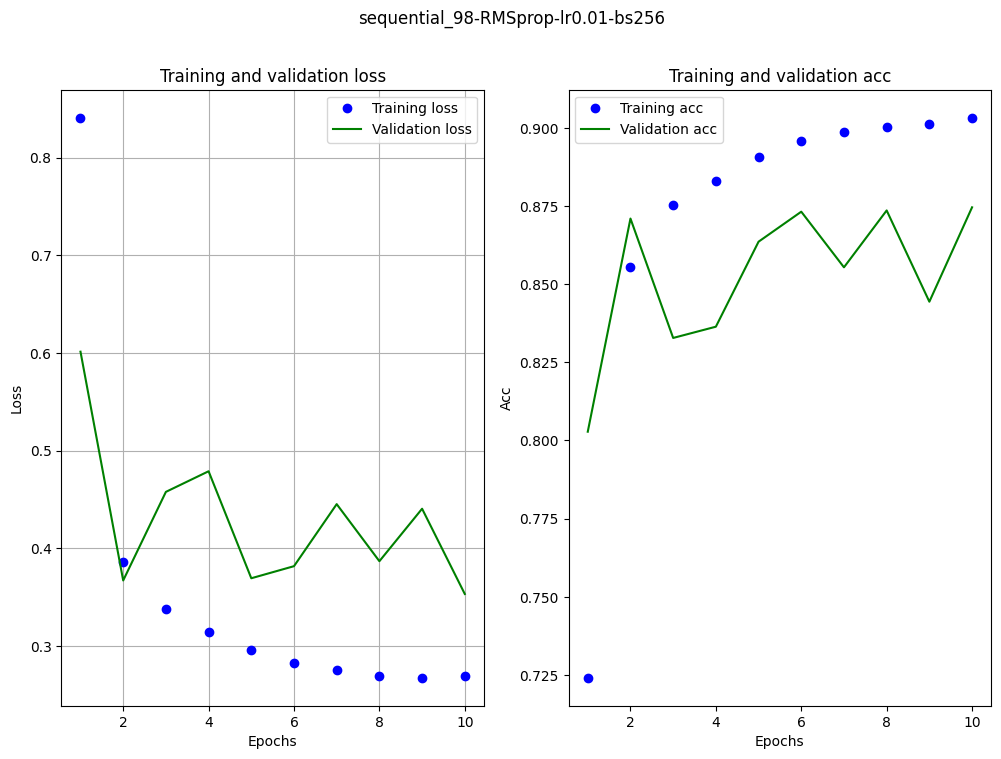

Epoch 1/10
235/235 [==============================] - 8s 31ms/step - loss: 0.7434 - categorical_accuracy: 0.7256 - val_loss: 0.5396 - val_categorical_accuracy: 0.7976
Epoch 2/10
235/235 [==============================] - 7s 31ms/step - loss: 0.4512 - categorical_accuracy: 0.8344 - val_loss: 0.4600 - val_categorical_accuracy: 0.8292
Epoch 3/10
235/235 [==============================] - 7s 31ms/step - loss: 0.3763 - categorical_accuracy: 0.8649 - val_loss: 0.3735 - val_categorical_accuracy: 0.8696
Epoch 4/10
235/235 [==============================] - 7s 31ms/step - loss: 0.3368 - categorical_accuracy: 0.8786 - val_loss: 0.3465 - val_categorical_accuracy: 0.8790
Epoch 5/10
235/235 [==============================] - 7s 31ms/step - loss: 0.3086 - categorical_accuracy: 0.8889 - val_loss: 0.3258 - val_categorical_accuracy: 0.8842
Epoch 6/10
235/235 [==============================] - 7s 31ms/step - loss: 0.2879 - categorical_accuracy: 0.8958 - val_loss: 0.3177 - val_categorical_accuracy: 0.888

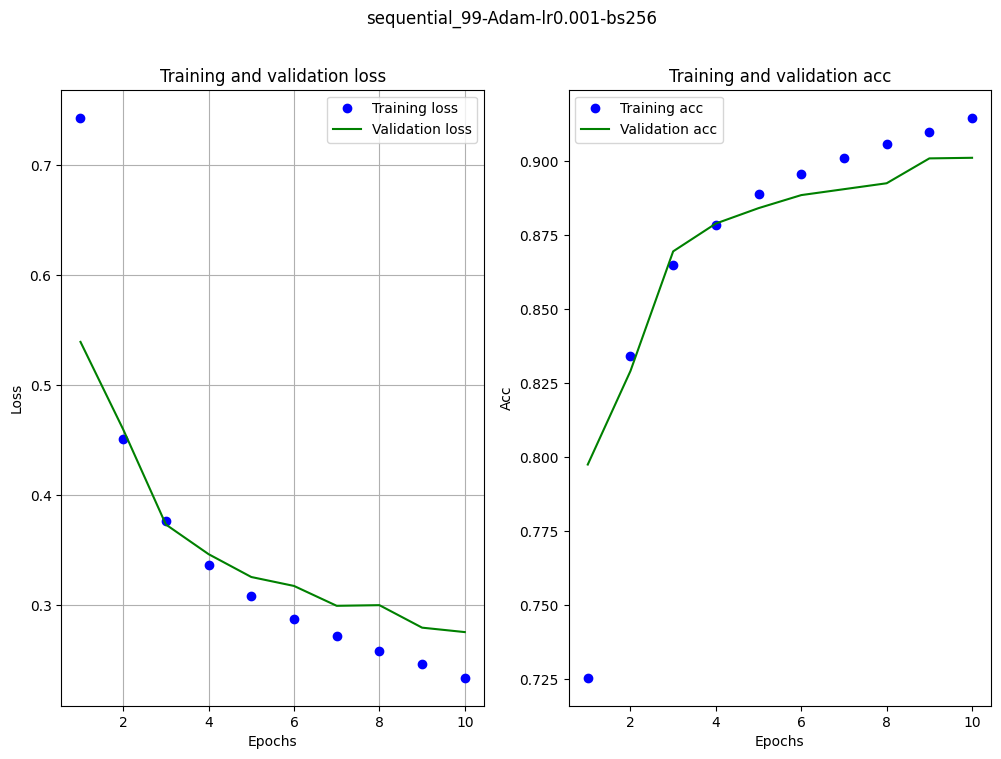

Epoch 1/10
235/235 [==============================] - 8s 33ms/step - loss: 0.5478 - categorical_accuracy: 0.7964 - val_loss: 0.3812 - val_categorical_accuracy: 0.8620
Epoch 2/10
235/235 [==============================] - 7s 31ms/step - loss: 0.3330 - categorical_accuracy: 0.8777 - val_loss: 0.3372 - val_categorical_accuracy: 0.8750
Epoch 3/10
235/235 [==============================] - 7s 31ms/step - loss: 0.2941 - categorical_accuracy: 0.8914 - val_loss: 0.3253 - val_categorical_accuracy: 0.8834
Epoch 4/10
235/235 [==============================] - 7s 31ms/step - loss: 0.2735 - categorical_accuracy: 0.8982 - val_loss: 0.3044 - val_categorical_accuracy: 0.8936
Epoch 5/10
235/235 [==============================] - 7s 31ms/step - loss: 0.2583 - categorical_accuracy: 0.9048 - val_loss: 0.3159 - val_categorical_accuracy: 0.8866
Epoch 6/10
235/235 [==============================] - 7s 31ms/step - loss: 0.2438 - categorical_accuracy: 0.9086 - val_loss: 0.2998 - val_categorical_accuracy: 0.893

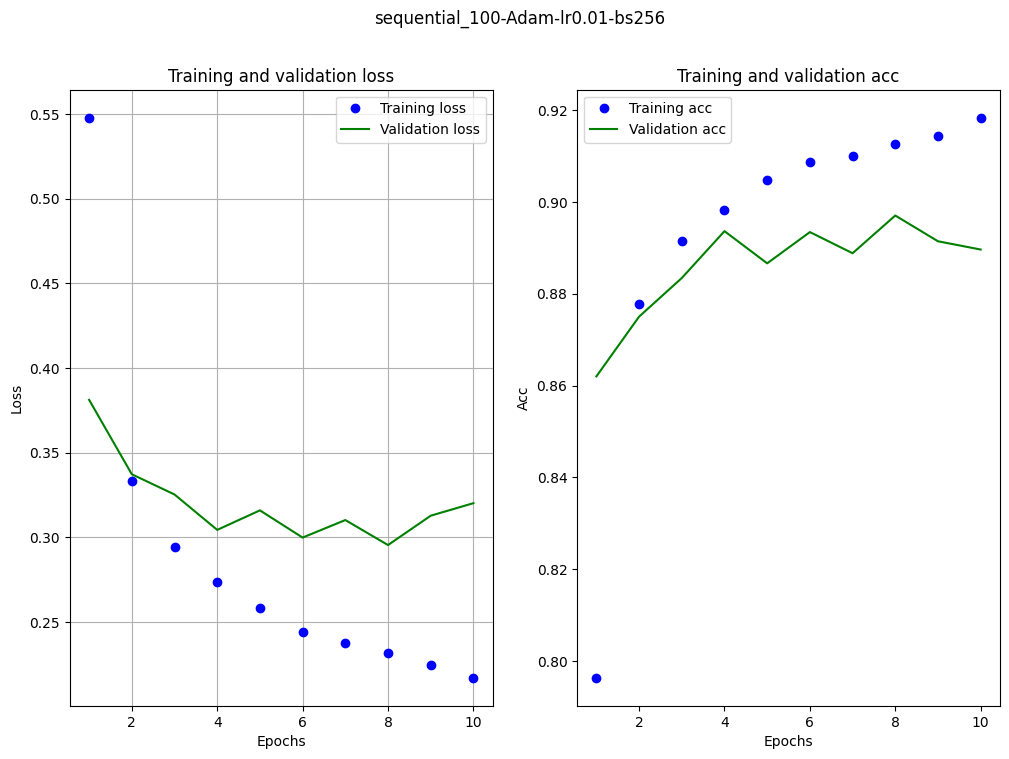

Epoch 1/10
118/118 [==============================] - 7s 58ms/step - loss: 2.3075 - categorical_accuracy: 0.1004 - val_loss: 2.3004 - val_categorical_accuracy: 0.1004
Epoch 2/10
118/118 [==============================] - 7s 57ms/step - loss: 2.2951 - categorical_accuracy: 0.0999 - val_loss: 2.2909 - val_categorical_accuracy: 0.1000
Epoch 3/10
118/118 [==============================] - 7s 57ms/step - loss: 2.2866 - categorical_accuracy: 0.1001 - val_loss: 2.2829 - val_categorical_accuracy: 0.1004
Epoch 4/10
118/118 [==============================] - 7s 57ms/step - loss: 2.2787 - categorical_accuracy: 0.1002 - val_loss: 2.2749 - val_categorical_accuracy: 0.1004
Epoch 5/10
118/118 [==============================] - 7s 57ms/step - loss: 2.2705 - categorical_accuracy: 0.1020 - val_loss: 2.2664 - val_categorical_accuracy: 0.1058
Epoch 6/10
118/118 [==============================] - 7s 57ms/step - loss: 2.2612 - categorical_accuracy: 0.1167 - val_loss: 2.2562 - val_categorical_accuracy: 0.130

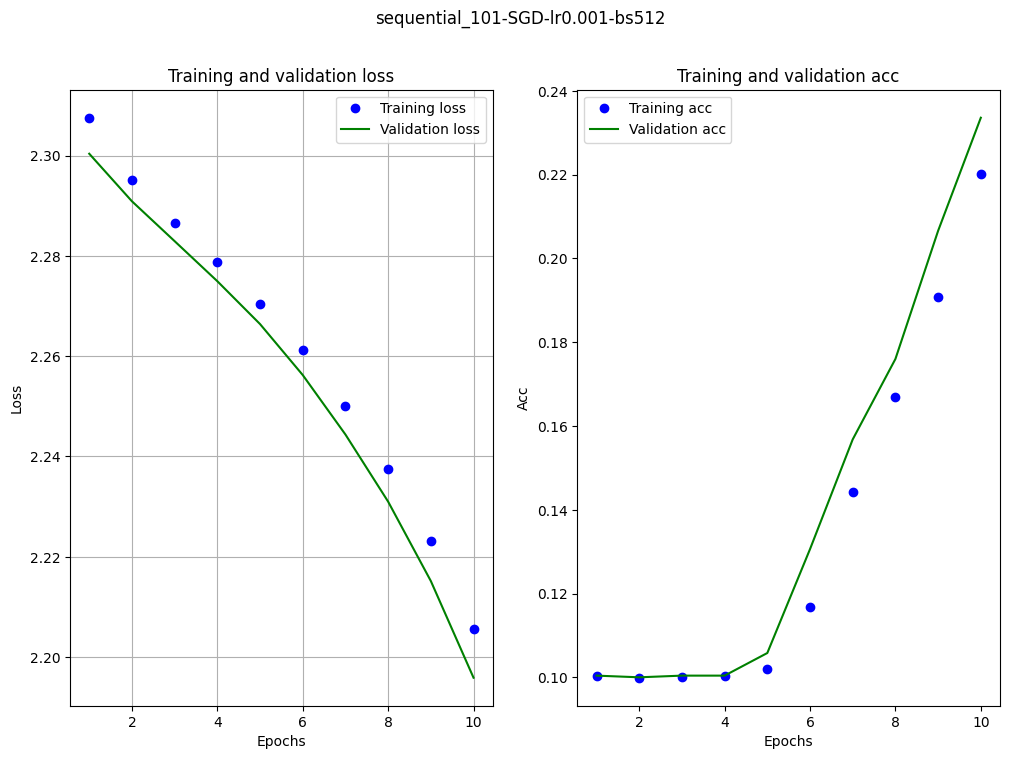

Epoch 1/10
118/118 [==============================] - 7s 59ms/step - loss: 2.2589 - categorical_accuracy: 0.1566 - val_loss: 2.1974 - val_categorical_accuracy: 0.3092
Epoch 2/10
118/118 [==============================] - 7s 58ms/step - loss: 1.9418 - categorical_accuracy: 0.4442 - val_loss: 1.4612 - val_categorical_accuracy: 0.5194
Epoch 3/10
118/118 [==============================] - 7s 57ms/step - loss: 1.1662 - categorical_accuracy: 0.5926 - val_loss: 1.2196 - val_categorical_accuracy: 0.5682
Epoch 4/10
118/118 [==============================] - 7s 58ms/step - loss: 0.9692 - categorical_accuracy: 0.6446 - val_loss: 1.0298 - val_categorical_accuracy: 0.6318
Epoch 5/10
118/118 [==============================] - 7s 57ms/step - loss: 0.8682 - categorical_accuracy: 0.6819 - val_loss: 0.8603 - val_categorical_accuracy: 0.6728
Epoch 6/10
118/118 [==============================] - 7s 58ms/step - loss: 0.8098 - categorical_accuracy: 0.7010 - val_loss: 0.9601 - val_categorical_accuracy: 0.649

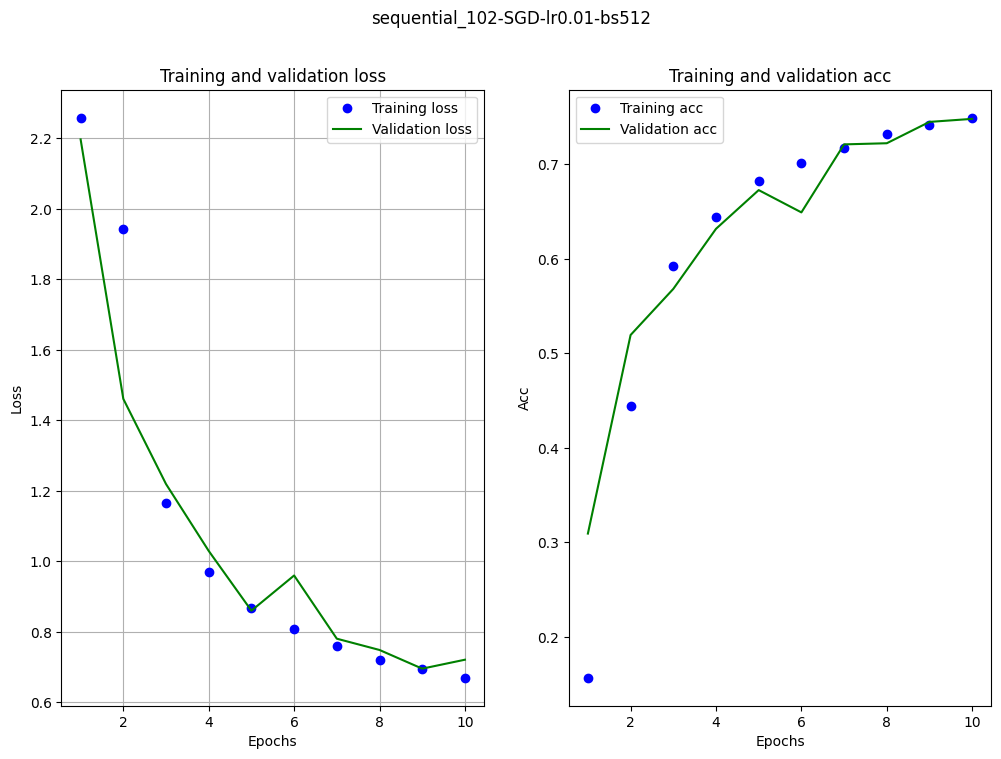

Epoch 1/10
118/118 [==============================] - 7s 58ms/step - loss: 0.9016 - categorical_accuracy: 0.6705 - val_loss: 0.6836 - val_categorical_accuracy: 0.7542
Epoch 2/10
118/118 [==============================] - 7s 58ms/step - loss: 0.5177 - categorical_accuracy: 0.8068 - val_loss: 0.5158 - val_categorical_accuracy: 0.8138
Epoch 3/10
118/118 [==============================] - 7s 57ms/step - loss: 0.4270 - categorical_accuracy: 0.8431 - val_loss: 0.5019 - val_categorical_accuracy: 0.8006
Epoch 4/10
118/118 [==============================] - 7s 58ms/step - loss: 0.3775 - categorical_accuracy: 0.8597 - val_loss: 0.4324 - val_categorical_accuracy: 0.8382
Epoch 5/10
118/118 [==============================] - 7s 57ms/step - loss: 0.3413 - categorical_accuracy: 0.8737 - val_loss: 0.3969 - val_categorical_accuracy: 0.8522
Epoch 6/10
118/118 [==============================] - 7s 58ms/step - loss: 0.3160 - categorical_accuracy: 0.8833 - val_loss: 0.3931 - val_categorical_accuracy: 0.859

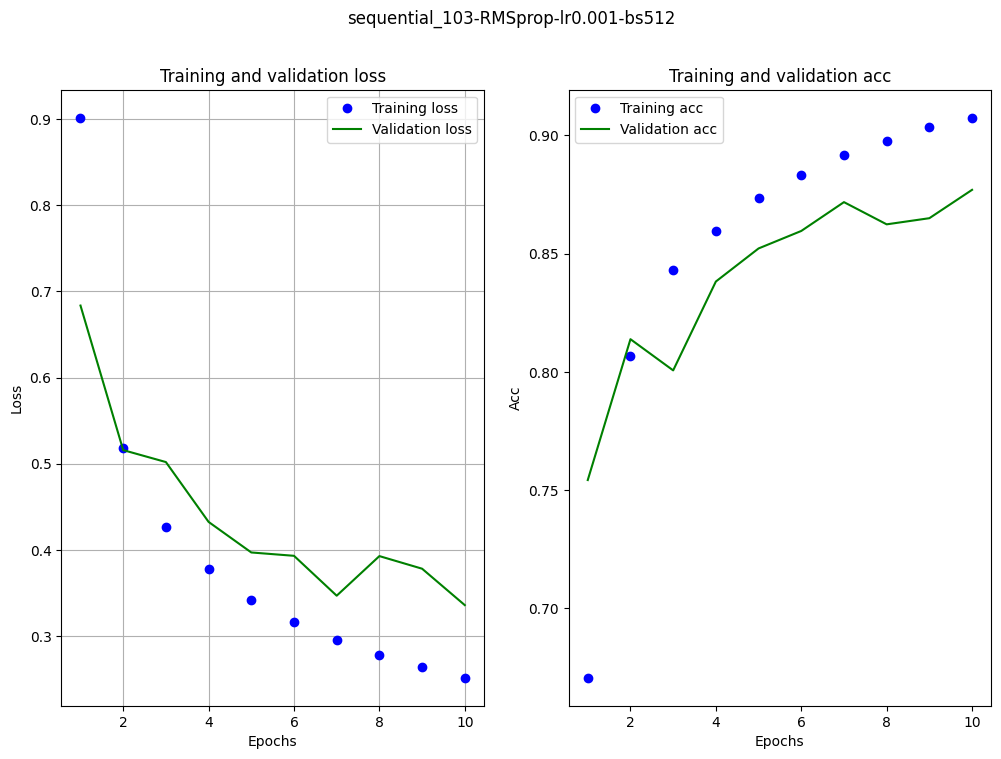

Epoch 1/10
118/118 [==============================] - 7s 58ms/step - loss: 1.1115 - categorical_accuracy: 0.6269 - val_loss: 0.6598 - val_categorical_accuracy: 0.7704
Epoch 2/10
118/118 [==============================] - 7s 58ms/step - loss: 0.4670 - categorical_accuracy: 0.8238 - val_loss: 0.4206 - val_categorical_accuracy: 0.8358
Epoch 3/10
118/118 [==============================] - 7s 57ms/step - loss: 0.3642 - categorical_accuracy: 0.8642 - val_loss: 0.4991 - val_categorical_accuracy: 0.8146
Epoch 4/10
118/118 [==============================] - 7s 58ms/step - loss: 0.3220 - categorical_accuracy: 0.8786 - val_loss: 0.3821 - val_categorical_accuracy: 0.8620
Epoch 5/10
118/118 [==============================] - 7s 58ms/step - loss: 0.2932 - categorical_accuracy: 0.8879 - val_loss: 0.5554 - val_categorical_accuracy: 0.8268
Epoch 6/10
118/118 [==============================] - 7s 57ms/step - loss: 0.2721 - categorical_accuracy: 0.8971 - val_loss: 0.4303 - val_categorical_accuracy: 0.862

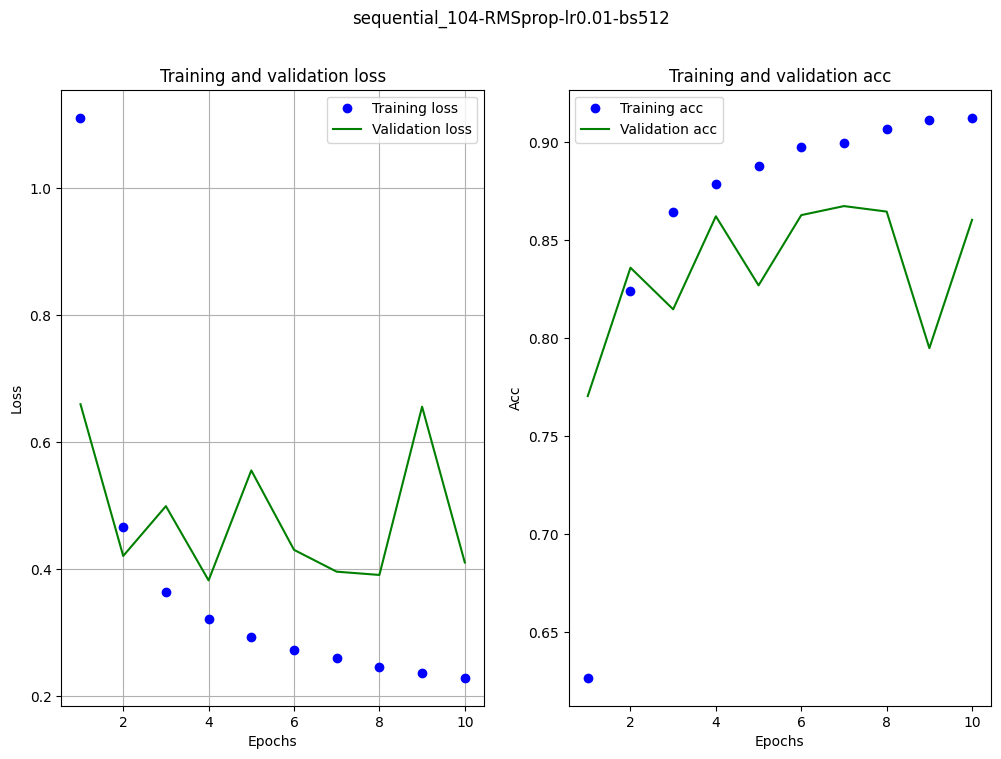

Epoch 1/10
118/118 [==============================] - 7s 58ms/step - loss: 0.8503 - categorical_accuracy: 0.7083 - val_loss: 0.5773 - val_categorical_accuracy: 0.7830
Epoch 2/10
118/118 [==============================] - 7s 58ms/step - loss: 0.4858 - categorical_accuracy: 0.8230 - val_loss: 0.4548 - val_categorical_accuracy: 0.8308
Epoch 3/10
118/118 [==============================] - 7s 58ms/step - loss: 0.4088 - categorical_accuracy: 0.8532 - val_loss: 0.4153 - val_categorical_accuracy: 0.8476
Epoch 4/10
118/118 [==============================] - 7s 57ms/step - loss: 0.3692 - categorical_accuracy: 0.8672 - val_loss: 0.3830 - val_categorical_accuracy: 0.8574
Epoch 5/10
118/118 [==============================] - 7s 58ms/step - loss: 0.3396 - categorical_accuracy: 0.8784 - val_loss: 0.3534 - val_categorical_accuracy: 0.8700
Epoch 6/10
118/118 [==============================] - 7s 57ms/step - loss: 0.3244 - categorical_accuracy: 0.8826 - val_loss: 0.3380 - val_categorical_accuracy: 0.878

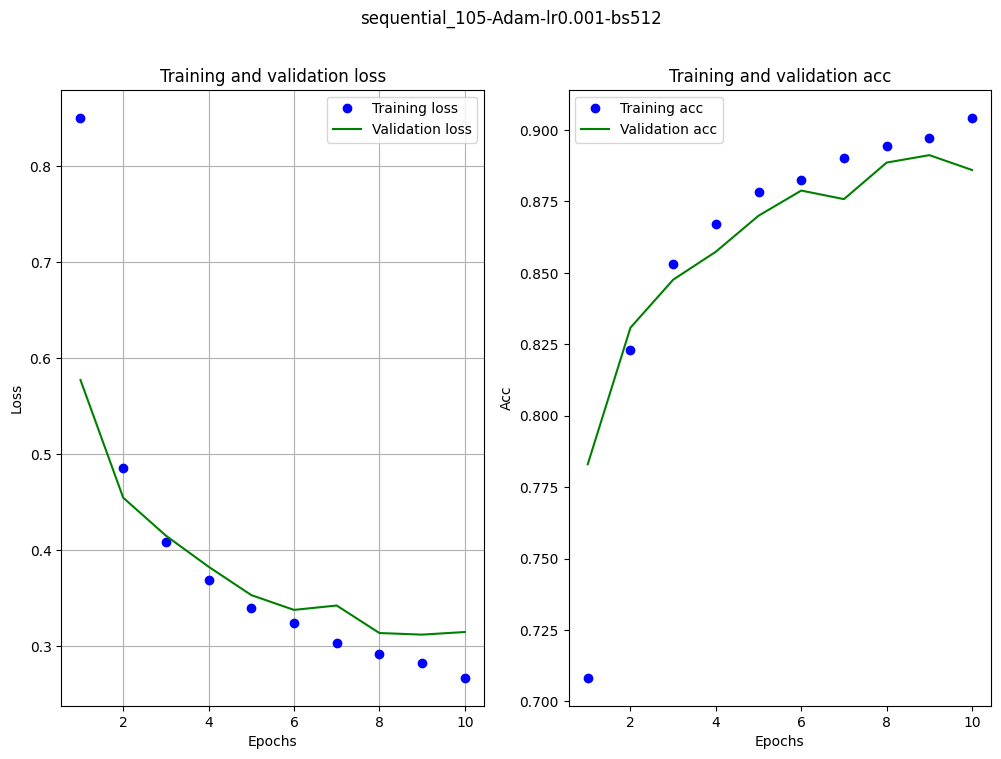

Epoch 1/10
118/118 [==============================] - 7s 59ms/step - loss: 0.7026 - categorical_accuracy: 0.7408 - val_loss: 0.4238 - val_categorical_accuracy: 0.8418
Epoch 2/10
118/118 [==============================] - 7s 57ms/step - loss: 0.3615 - categorical_accuracy: 0.8677 - val_loss: 0.3584 - val_categorical_accuracy: 0.8706
Epoch 3/10
118/118 [==============================] - 7s 57ms/step - loss: 0.3176 - categorical_accuracy: 0.8831 - val_loss: 0.3518 - val_categorical_accuracy: 0.8712
Epoch 4/10
118/118 [==============================] - 7s 57ms/step - loss: 0.2862 - categorical_accuracy: 0.8942 - val_loss: 0.3237 - val_categorical_accuracy: 0.8848
Epoch 5/10
118/118 [==============================] - 7s 58ms/step - loss: 0.2629 - categorical_accuracy: 0.9029 - val_loss: 0.3241 - val_categorical_accuracy: 0.8814
Epoch 6/10
118/118 [==============================] - 7s 58ms/step - loss: 0.2550 - categorical_accuracy: 0.9041 - val_loss: 0.3297 - val_categorical_accuracy: 0.881

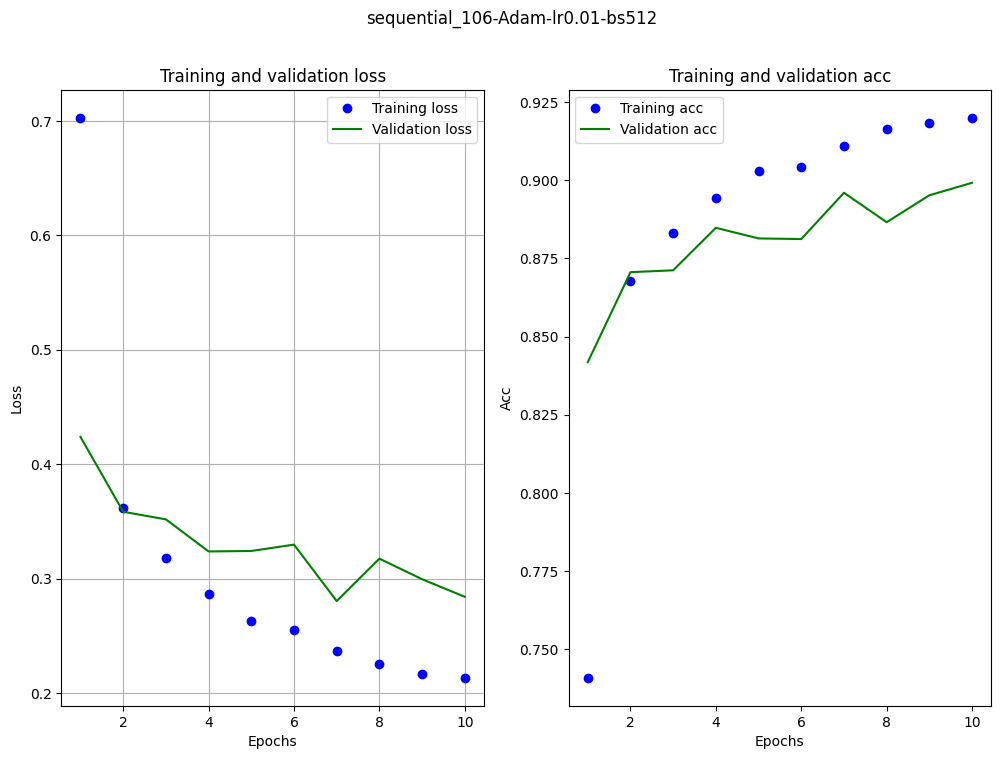

In [208]:
for model_name, model in my_models.items():
    train_1 = TrainerModelConv2D(model)
    train_1.train(x=images_train, y=labels_train, epochs=cfg.get('epochs_limit'), batch_size=int(model_name.split('bs')[1]), validation_data=(images_valid, labels_valid))
    train_1.draw_results(model_name)